# **EYE FOR BLIND**

### Background
The World Health Organization (WHO) has reported that approximately 285 million people are visually impaired worldwide, and out of these 285 million, 39 million are completely blind. It gets extremely tough for them to carry out daily activities, one of which is reading. From reading a newspaper or a magazine to reading an important text message from your bank, it is tough for them to read the text written in it.


###Problem Statement: 

Create a Deep learning model which would be able to convert an Image to text ( understandable sentences) and also give an output in audio. 

### Proposed approach

We will follow the following steps 

1. Reading the Flickr data set. The Date set is comprised of the images and the captions associated with it. 
2. Performing EDA and understanding the data set. Cleaning it in the process. Removing stopwords.  
3. Data is preprocessed. tokenising the captions and forming an embebbded vector. Preprocessing the Images.
4. Splitting in to Train and Test dataset. 
5. Using the InceptionV3 model for image recognition. InceptionV3 achieves ~ 78% accuracy on the ImageNet dataset.This is what we will use for the Feature vector.
6. From this feature vector, we will remove the softmax(since we are not classifying images) and use it as input to the CNN encoder. 
7. The output will be fed to a RNN GRU Decoder with an Attention Model for phrase prediction. 

## 1. Importing all Relavent libreries


In [1]:

!pip install wordcloud
!pip install gTTs
!pip install playsound

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import glob

from skimage import io
pd.set_option('display.max_colwidth',-1)

import collections
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from playsound import playsound
from IPython import display
from gtts import gTTS


  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=f342778a7a242175cc65933e27cef176691a292ac4041d19472e4e326aac998b
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]
playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## 2. Reading the Flickr data Set 

The Data set comprises of 8000+ images with a text file to train captions. Each image has 5 captions

In [2]:
# reading the Flickr Data set


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:

images='/content/gdrive/MyDrive/Colab Notebooks/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print('Total images' ,len(all_imgs))

Total images 8091


### Visualise images & text 

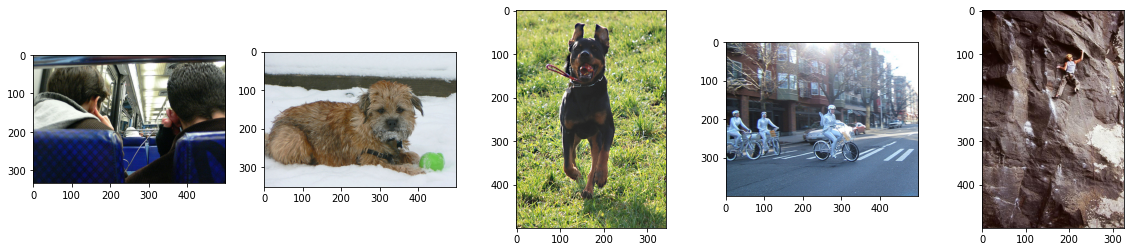

In [7]:
#First 5 images:

Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [8]:
#Read text file

text_file = '/content/gdrive/MyDrive/Colab Notebooks/captions.txt'

def load_doc(text_file):
    open_file = open(text_file, 'r', encoding="latin-1")
    text = open_file.read() 
    print(text)
    open_file.close()    
    return text

doc = load_doc(text_file)
print(doc[299:300])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
#List of top 5 images

all_imgs[:5]

['/content/gdrive/MyDrive/Colab Notebooks/Images/397601572_9587a39291.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Images/374567836_3ae12ecffb.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Images/408573233_1fff966798.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Images/375171241_0302ad8481.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Images/405537503_f66ecc5073.jpg']

In [11]:
# Creating a Data frame for all the Images and text together

image_path='/content/gdrive/MyDrive/Colab Notebooks/Images/'
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

with open('/content/gdrive/MyDrive/Colab Notebooks/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
        
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin
...,...,...,...
40450,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles
40453,997722733_0cb5439472.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt


### Counting words in the captions

In [12]:
#Now we will count the number of words in teh captions

vocabulary= [word.lower() for line in annotations for word in line.split()]

val_count=collections.Counter(vocabulary)
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Counts')

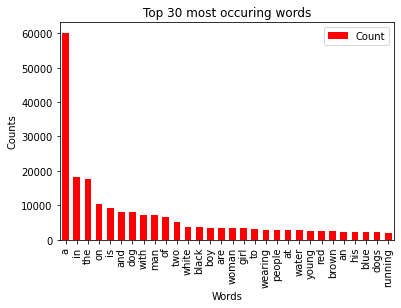

In [13]:
#Visualise the top 30 occuring words in the captions

#write your code here
for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")


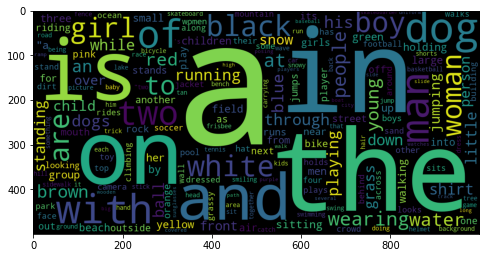

In [15]:
# using wordcloud to visaulise it

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.show()

There are many stopwords which would need to be removed such as a, the etc ( to further understand on stop words, please refer https://en.wikipedia.org/wiki/Stop_word)

#### 30 Most common words after removing stopwords

dog :  7948
man :  7137
two :  5132
white :  3706
black :  3620
boy :  3514
woman :  3304
girl :  3277
wearing :  2916
people :  2811
water :  2676
young :  2587
red :  2553
brown :  2457
blue :  2125
dogs :  2095
running :  1996
playing :  1954
little :  1736
shirt :  1735
standing :  1702
ball :  1678
grass :  1565
person :  1515
child :  1507
snow :  1439
jumping :  1430
front :  1322
sitting :  1322
small :  1257


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

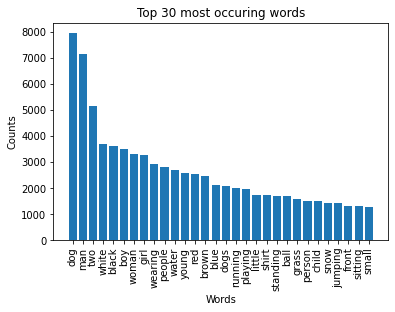

In [16]:
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        print(word, ": ", count)

dict_without_stopwords = {}
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        dict_without_stopwords[word] = count


plt.bar(range(len(dict_without_stopwords)), dict_without_stopwords.values(), align='center')
plt.xticks(range(len(dict_without_stopwords)), list(dict_without_stopwords.keys()))
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.xticks(rotation=90)


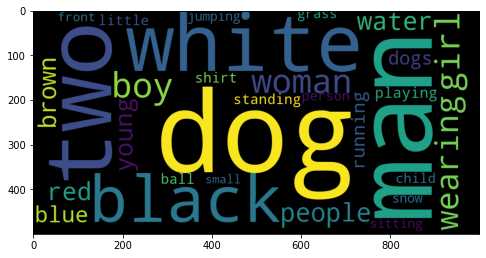

In [17]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict_without_stopwords)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


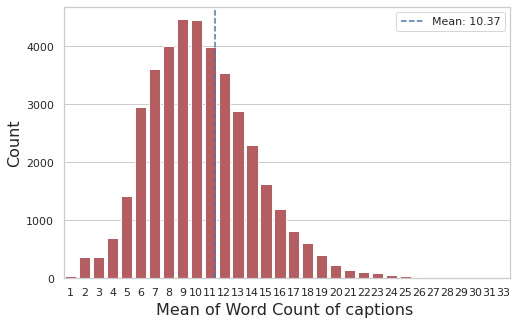

In [18]:
# find the mean and distribution of the word count in the captions 

caption_df=df.copy()
caption_df['caption_word_count'] = caption_df["Captions"].str.split().str.len()

mean = sum(caption_df['caption_word_count'])/len(caption_df['caption_word_count'])

sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(8, 5))
ax = sns.countplot(caption_df['caption_word_count'], color="r")
plt.xlabel('Mean of Word Count of captions ', fontsize=16)
plt.ylabel('Count', fontsize=16)
ax.axvline(mean, color='b', linestyle='--')
plt.legend({'Mean: {:.2f}'.format(mean): mean})

In [20]:
caption_df.head()

,ID,Path,Captions,caption_word_count
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way,17
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building,7
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse,8
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse,9
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin,12


### Data Cleaning 

In [21]:
# converting to lower case, removign punthuations, removing 1 letter words

remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] 
    line = [word.translate(remove_punctuation) for word in line]
    line = [word for word in line if len(word)>1] 
    line = [word for word in line if word.isalpha()]
    annotations[i]=  ' '.join(line)   

In [22]:
#Create a list which contains all the captions

#add the <start> & <end> token to all those captions as well
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [23]:
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

## Pre-Processing the captions


1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Create the tokenizer

- We have already removed numeric character in previous step. 
- Let's remove punctuations using filter again for to be sure(The default is all punctuation, plus tabs and line breaks, minus the ' character.)

- Convert words to lower case (this is also already done.Let's do again to be safe) 
- And,replace out-of-vocabulary words with UNK token and assign PAD token for reseved zero index

In [24]:
top_voc = 5000
tokenizer =Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="UNK")


# Create word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations) #Updates internal vocabulary based on a list of texts.

train_seqs = tokenizer.texts_to_sequences(annotations)#Transforms each text in texts to a sequence of integers.

# when we use the pad_sequence to process the sequence, we will be using 0 as the padding value.
# In order to distinguish between PAD and UNKNOWN, keras use different index for UNKNOWN.

# 0 is a reserved index that won't be assigned to any word.Let's add PAD token for zero

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'


In [25]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [26]:
tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [28]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('child', 1517),
             ('in', 18182),
             ('pink', 702),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 490),
             ('up', 1215),
             ('set', 105),
             ('of', 6496),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 48),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17676),
             ('to', 3005),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3627),
             ('dog', 7956),
             ('and', 8057),
             ('spotted', 36),
             ('are', 3365),
             ('fighting', 130),
             ('tricolored', 12),
             ('playing', 1954),
        

In [ ]:
annotations[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [29]:
train_seqs[:5]

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [30]:
print(len(train_seqs))

40455


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


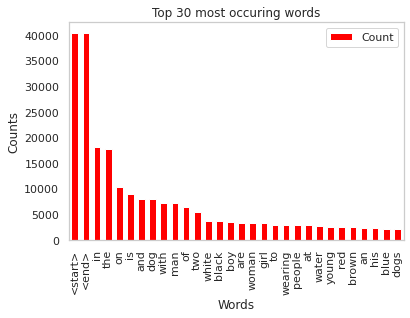

In [31]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.grid(b=None)

In [32]:
# Pad each vector to the max_length of the captions & store it to a vairable

train_seqs_len=[len(seq) for seq in train_seqs] #storing all lengths in list.Can be used if needed in future
longest_word_length= max(train_seqs_len) #Python list method max returns the elements from the list with maximum value.

# Calculates the longest_word_length to pad all sequences to be the same length as the longest one.

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [33]:
IMAGE_SHAPE= (299, 299)

In [34]:
#Let's see how preprocessed image looks by preprocessing first 5 images alone.
preprocessed_img=[]
for img in all_imgs[0:5]:
    img = tf.io.read_file(img,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=0) #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


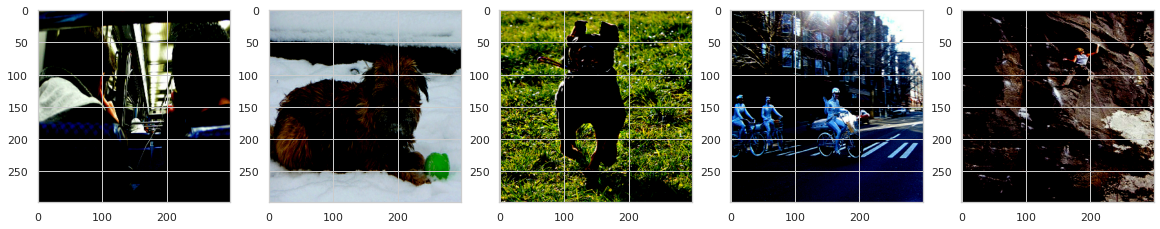

In [35]:
Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image)
    ax.grid('off')

We can now write a function tfor preprocessing so that we can vectorise and pre process images parallely

In [38]:
def preprocessImagesFunction(image_path):

    img = tf.io.read_file(image_path,name=None)
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    return img, image_path

## Splitting Data into Train and Test


In [39]:

# mapping each image full path including name to the function to preprocess the image

# sorting and storing unique path in list which will be given as input 
training_list = sorted(set(all_img_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)

# Mappng preprocessImagesFunction across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(preprocessImagesFunction, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [40]:
New_Image_Data

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [41]:
# performing the train-test spliit using 80-20 ratio & random state = 42

img_train_data, img_test_data, caption_train_data, caption_test_data = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [42]:
print("No of images in training dataset: ",len(img_train_data))
print("No of images in testing dataset: ",len(img_test_data))
print("No of captions in training dataset: ",len(caption_train_data))
print("No of captions in testing dataset: ",len(caption_test_data))


No of images in training dataset:  32364
No of images in testing dataset:  8091
No of captions in training dataset:  32364
No of captions in testing dataset:  8091


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the image using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)


In [43]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

#image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer


87924736/87910968 [==============================] - 1s 0us/step


In [44]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

Here,we only need to extract an image vector for our images.Hence we are removing the softmax layer from the model.

In [45]:
# Extract features from each image in the dataset
image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    #fb_shape = features_for_batch.get_shape().as_list()
    #features_for_batch_flattened = tf.contrib.layers.flatten(fb_shape) 
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()


100%|██████████| 127/127 [17:32<00:00,  8.29s/it]


In [46]:
features_for_batch

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.76500031e-02, 0.00000000e+00, ...,
          2.31816277e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07777871e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.93898663e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85778394e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.43677947e-02, 0.00000000e+00, 5.05890131e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.22805876e-01, 1.35347582e-02, ...,
          2.33625740e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [47]:
features_for_batch_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7650003e-02, 0.0000000e+00, ...,
         2.3181628e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0777787e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9389866e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8577839e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6571518e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0259245e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1797329e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5346816e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2507510e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8292996e-02, ...,
         1.2065883e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [48]:
print(len(image_features_dict))
batch_feat.shape

8091


TensorShape([64, 2048])

In [49]:
import more_itertools
top_5_items = more_itertools.take(5, image_features_dict.items())

top_5_items #printing first 5 elememts have dictionary

[('/content/gdrive/MyDrive/Colab Notebooks/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16988818],
         [0.        , 0.        , 1.0106202 , ..., 0.        , 0.        ,
          0.06110416],
         ...,
         [0.        , 0.        , 2.037989  , ..., 1.2033163 , 0.        ,
          1.9922264 ],
         [0.        , 0.        , 0.9047285 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2529362 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('/content/gdrive/MyDrive/Colab Notebooks/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.664062  , 0.46306533, ..., 0.        , 0.        ,
          3.332647  ],
         [0.        , 1.227077  , 0.        , ..., 0.        , 0.25423333,
          3.329993  ],
         [1.2881067 , 1.5198

In [51]:
#passing images and captions to the input
def modelInput(image,captions):
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final,captions

In [52]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64 

def dataGenerator(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(modelInput, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 
    return dataset

In [53]:
train_dataset=dataGenerator(img_train_data,caption_train_data) 
test_dataset=dataGenerator(img_test_data,caption_test_data) 

In [70]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [54]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train_data) // BATCH_SIZE  #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test_data) // BATCH_SIZE   #len(total test images) // BATCH_SIZE
max_length=31
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

## ENCODER

In [63]:
tf.compat.v1.reset_default_graph() 


In [64]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        #It acts as the fully connected layer
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features

In [65]:
encoder=Encoder(embedding_dim)

# Attention Model 

The following is the Attension model. 

The attention model does a linear transformation of the input.So we are applying tanh function on top of it.The features produced from dense layer(FC layer) of encoder and hidden state of decoder are passed to tanh function and attention score is calculated.



In [66]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

## Decoder

In [67]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [68]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [71]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [72]:
optimizer =tf.keras.optimizers.Adam(learning_rate=0.001) #define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE) 


In [73]:
def lossFunction(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # we are multiplying loss with mask to get ideal shape

    return tf.reduce_mean(loss_)

In [74]:
checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks/Images"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [75]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [76]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += lossFunction(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

In [77]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += lossFunction(target[:, t], predictions) 

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch
    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

Here we are using teacher forcing. This enforces the training to converge faster. 

In the initial steps , the predictions of the model can be wrong / bad. If we do not use teacher forcing, the hidden state of the model might get updated with a sequence of wrong predictions, because it reads the relations between words. This misleads teh model. So we pass pargetted words as next input to decoder initially to force the learning. 

In [78]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [79]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.443, & test loss is 1.201
Time taken for 1 epoch 167.74750089645386 sec

Test loss has been reduced from 100.000 to 1.201


  7%|▋         | 1/15 [02:48<39:14, 168.21s/it]

For epoch: 2, the train loss is 1.110, & test loss is 1.058
Time taken for 1 epoch 67.59356832504272 sec

Test loss has been reduced from 1.201 to 1.058


 13%|█▎        | 2/15 [03:56<23:39, 109.23s/it]

For epoch: 3, the train loss is 1.005, & test loss is 0.971
Time taken for 1 epoch 67.56910252571106 sec

Test loss has been reduced from 1.058 to 0.971


 20%|██        | 3/15 [05:04<18:04, 90.38s/it] 

For epoch: 4, the train loss is 0.933, & test loss is 0.905
Time taken for 1 epoch 67.49755239486694 sec

Test loss has been reduced from 0.971 to 0.905


 27%|██▋       | 4/15 [06:11<14:56, 81.48s/it]

For epoch: 5, the train loss is 0.873, & test loss is 0.849
Time taken for 1 epoch 67.45169019699097 sec

Test loss has been reduced from 0.905 to 0.849


 33%|███▎      | 5/15 [07:19<12:45, 76.55s/it]

For epoch: 6, the train loss is 0.820, & test loss is 0.799
Time taken for 1 epoch 67.44037890434265 sec

Test loss has been reduced from 0.849 to 0.799


 40%|████      | 6/15 [08:27<11:02, 73.58s/it]

For epoch: 7, the train loss is 0.772, & test loss is 0.752
Time taken for 1 epoch 67.34491324424744 sec

Test loss has been reduced from 0.799 to 0.752


 47%|████▋     | 7/15 [09:35<09:33, 71.66s/it]

For epoch: 8, the train loss is 0.729, & test loss is 0.710
Time taken for 1 epoch 67.28369307518005 sec

Test loss has been reduced from 0.752 to 0.710


 53%|█████▎    | 8/15 [10:42<08:12, 70.39s/it]

For epoch: 9, the train loss is 0.687, & test loss is 0.669
Time taken for 1 epoch 67.2802894115448 sec

Test loss has been reduced from 0.710 to 0.669


 60%|██████    | 9/15 [11:50<06:57, 69.53s/it]

For epoch: 10, the train loss is 0.649, & test loss is 0.629
Time taken for 1 epoch 67.34263277053833 sec

Test loss has been reduced from 0.669 to 0.629


 67%|██████▋   | 10/15 [12:58<05:44, 68.97s/it]

For epoch: 11, the train loss is 0.615, & test loss is 0.594
Time taken for 1 epoch 67.24711489677429 sec

Test loss has been reduced from 0.629 to 0.594


 73%|███████▎  | 11/15 [14:05<04:34, 68.56s/it]

For epoch: 12, the train loss is 0.582, & test loss is 0.564
Time taken for 1 epoch 67.2300910949707 sec

Test loss has been reduced from 0.594 to 0.564


 80%|████████  | 12/15 [15:13<03:24, 68.27s/it]

For epoch: 13, the train loss is 0.552, & test loss is 0.533
Time taken for 1 epoch 67.1709816455841 sec

Test loss has been reduced from 0.564 to 0.533


 87%|████████▋ | 13/15 [16:21<02:16, 68.05s/it]

For epoch: 14, the train loss is 0.523, & test loss is 0.506
Time taken for 1 epoch 67.22251844406128 sec

Test loss has been reduced from 0.533 to 0.506


 93%|█████████▎| 14/15 [17:28<01:07, 67.91s/it]

For epoch: 15, the train loss is 0.496, & test loss is 0.484
Time taken for 1 epoch 67.19541311264038 sec

Test loss has been reduced from 0.506 to 0.484


100%|██████████| 15/15 [18:36<00:00, 74.42s/it]


NOTE:
- Since there might be difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.[ Actual observation It does not happen]
- This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
- Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

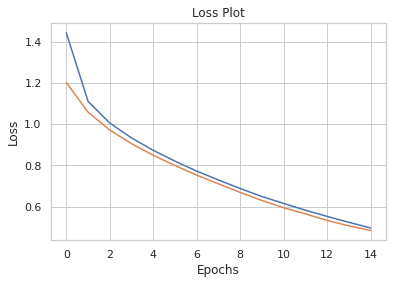

In [80]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid('off')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search 

In [81]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocessImagesFunction(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [82]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [83]:
from nltk.translate.bleu_score import sentence_bleu

In [84]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [85]:
img_test=img_test_data.copy()

In [88]:
# functionising the code given 
def predCaptionAudio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

    cap_test=caption_test_data.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #Using  Google Text to Speech Online API from playing the predicted caption as audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
    
    return test_image

## Using Test Date for prediction 

BELU score: 57.73502691896258
Real Caption: white dog and brown dog fighting
Prediction Caption: white dog and brown dog is sniffing the dead grass


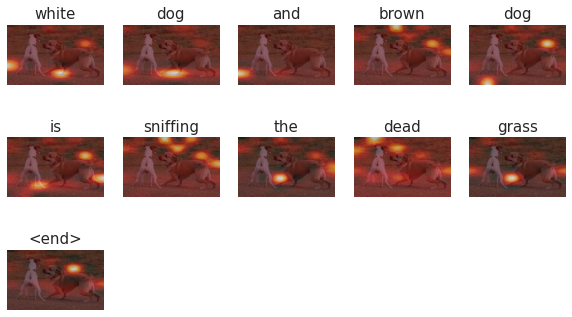

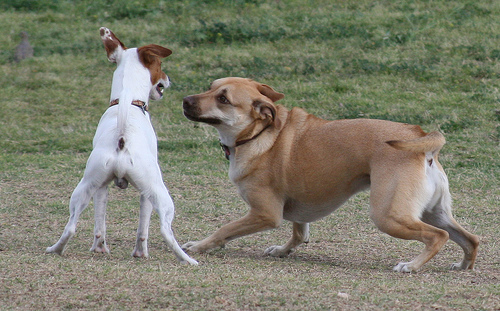

In [90]:
test_image=predCaptionAudio(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 46.68330721298284
Real Caption: woman in black cap and outfit sits in the sand
Prediction Caption: woman in black cap is sitting on rock wall


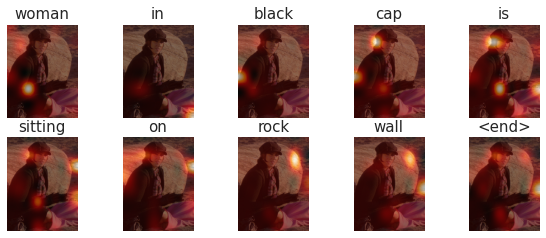

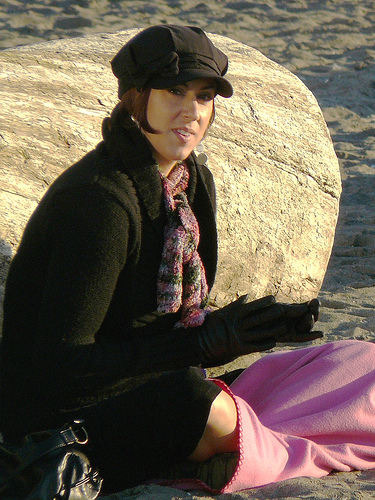

In [91]:
test_image=predCaptionAudio(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 54.88116360940264
Real Caption: two women crossing the street on cold day
Prediction Caption: two women crossing the street


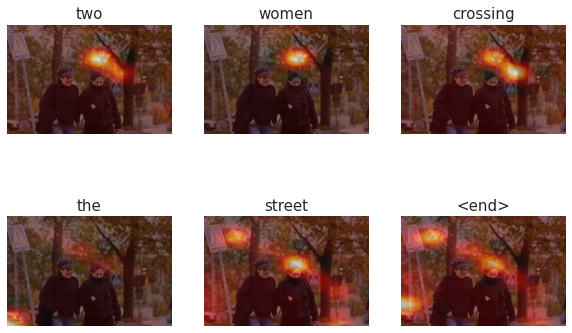

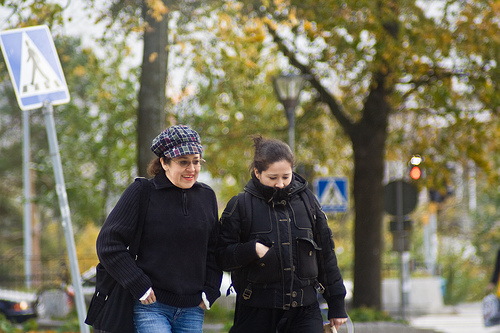

In [93]:
test_image=predCaptionAudio(len(img_test),True,weights=(0.5,0.25,0,0))

Image.open(test_image)

## Concludin remarks for the project 

- We have used the InceptionV3 model for generating the  feature vector. Since we are not classifying the images and only extracting  a featire vector for our images, we removed  the softmax layer from the model and then squeezed it.

- This feature vector is given as input to CNN Encoder which had a single fully connected layer.

- The decoder (RNN -here GRU) attends over the image to predict the next word.

-  We used the attention model to make our decoder focus on a particular part of the image at a time rather than focusing on the entire image. 

- The decoder stop predicting when the model predicts the end token.

- The prediction of the words by the model is done by finding out the probabilities of that word in the vocabulary.

- We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

- Finally, we are using the "BLEU score"(Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption 


